In [1]:
import os
import glob
import math
from collections import defaultdict

In [ ]:
root_dir = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/regional-traffic-flow"
output_dir = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/all"

regions = [
    "aix-en-provence",
    "est-etang-de-berre",
    "marseille",
    "nord-ouest",
    "ouest-etang-de-berre",
    "sud-est"
]

os.makedirs(output_dir, exist_ok=True)

hour_files = []
for h in range(24):
    h_next = (h + 1) % 24
    h_str = f"{h:02d}"
    hn_str = f"{h_next:02d}"
    filename = f"OD_{h_str}-{hn_str}.txt"
    hour_files.append(filename)

for hour_fname in hour_files:
    od_values = defaultdict(list)
    header_lines = []
    found_header = False

    for region in regions:
        od_folder = os.path.join(root_dir, region, "od_matrices")
        file_path = os.path.join(od_folder, hour_fname)
        if not os.path.isfile(file_path):
            print(f"Warning: file not found {file_path}, skipping.")
            continue

        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        if not found_header:
            header_lines = lines[:3]
            found_header = True

        for line in lines[3:]:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 3:
                continue
            origin = parts[0]
            destination = parts[1]
            try:
                value = float(parts[2])
            except ValueError:
                continue
            key = (origin, destination)
            od_values[key].append(value)

    merged_lines = []
    for (orig, dest), vals in od_values.items():
        avg_val = sum(vals) / len(vals)
        rounded_val = math.ceil(avg_val)
        merged_lines.append((int(orig), int(dest), rounded_val))

    merged_lines.sort(key=lambda x: (x[0], x[1]))

    out_path = os.path.join(output_dir, hour_fname)
    with open(out_path, "w", encoding="utf-8") as fo:
        for hl in header_lines:
            fo.write(hl.rstrip("\n") + "\n")
        for orig, dest, val in merged_lines:
            fo.write(f"{orig:>9}{dest:>9}{val:9d}\n")

    print(f"Wrote merged file: {out_path}")

print("Finished merging 24 OD files!")


In [ ]:
merged_dir = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario"

inter_dir = os.path.join(merged_dir, "inter-region")
intra_dir = os.path.join(merged_dir, "intra-region")
os.makedirs(inter_dir, exist_ok=True)
os.makedirs(intra_dir, exist_ok=True)

all_files = [
    f for f in os.listdir(merged_dir)
    if f.startswith("OD_") and f.endswith(".txt") and os.path.isfile(os.path.join(merged_dir, f))
]

for fname in sorted(all_files):
    path_in = os.path.join(merged_dir, fname)
    path_inter = os.path.join(inter_dir, fname)
    path_intra = os.path.join(intra_dir, fname)

    with open(path_in, "r", encoding="utf-8") as f:
        lines = f.readlines()

    header = lines[:3]
    data_lines = lines[3:]

    inter_lines = []
    intra_lines = []
    count_inter = 0
    count_intra = 0

    for line in data_lines:
        line = line.strip()
        if not line:
            continue

        parts = line.split()
        if len(parts) < 3:
            continue

        origin = parts[0]
        destination = parts[1]

        if origin == destination:
            intra_lines.append(line)
            count_intra += 1
        else:
            inter_lines.append(line)
            count_inter += 1

    print(f"File: {fname}")
    print(f"  - Intra-region lines (O = D): {count_intra}")
    print(f"  - Inter-region lines (O ≠ D): {count_inter}")
    print("")

    with open(path_inter, "w", encoding="utf-8") as fo_inter:
        for h in header:
            fo_inter.write(h)
        for ln in inter_lines:
            fo_inter.write(ln + "\n")

    with open(path_intra, "w", encoding="utf-8") as fo_intra:
        for h in header:
            fo_intra.write(h)
        for ln in intra_lines:
            fo_intra.write(ln + "\n")

print("Finished: statistics and split completed for all files.")


Finished: statistics and split completed for all files.


In [2]:
root_dir = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/all"

def is_od_file(fname):
    return fname.startswith("OD_") and fname.endswith(".txt")

directed_totals = defaultdict(float)
intra_totals = defaultdict(float)
time_totals = defaultdict(float)  # Aggregate total trips per file/time
grand_total = 0.0
inter_total = 0.0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for fname in filenames:
        if not is_od_file(fname):
            continue

        # Derive a time identifier from the filename (everything between "OD_" and ".txt")
        time_id = fname[len("OD_"):-len(".txt")]

        fpath = os.path.join(dirpath, fname)
        try:
            with open(fpath, "r", encoding="utf-8") as f:
                lines = f.readlines()
        except Exception as e:
            print(f"Warning: could not read file {fpath}: {e}")
            continue

        data_lines = lines[3:]
        file_total = 0.0  # Sum of trips in this specific file

        for raw in data_lines:
            line = raw.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 3:
                continue

            origin = parts[0]
            destination = parts[1]
            try:
                value = float(parts[2])
            except ValueError:
                continue

            directed_totals[(origin, destination)] += value
            grand_total += value
            file_total += value

            if origin == destination:
                intra_totals[origin] += value
            else:
                inter_total += value

        # After processing this file, record its total
        time_totals[time_id] += file_total

all_regions = set()
for origin, destination in directed_totals:
    all_regions.add(origin)
    all_regions.add(destination)
all_regions = sorted(all_regions, key=lambda r: int(r))

print("----- DETAILED TRIP STATISTICS -----")
print(f"Total trips (all)                       : {grand_total:,.2f}")
print(f"Total intra-region trips (O = D)        : {sum(intra_totals.values()):,.2f}")
print(f"Total inter-region trips (O ≠ D)        : {inter_total:,.2f}")
print("")

# Print total trips by time (based on filenames)
print("Total trips by time:")
for time_id in sorted(time_totals, key=lambda x: int(x) if x.isdigit() else x):
    total_for_time = time_totals[time_id]
    print(f"  Time {time_id:<10} : {total_for_time:,.2f}")
print("")

print("Intra-region totals:")
for region in all_regions:
    intra = intra_totals.get(region, 0.0)
    print(f"  Region {region:>3} : {intra:,.2f}")
print("")

print("Inter-region flows (directed and undirected):")
for i, origin in enumerate(all_regions):
    for destination in all_regions[i+1:]:
        od = directed_totals.get((origin, destination), 0.0)
        do_ = directed_totals.get((destination, origin), 0.0)
        combined = od + do_

        if combined > 0:
            print(f"  Region {origin} -> Region {destination} : {od:,.2f}")
            print(f"  Region {destination} -> Region {origin} : {do_:,.2f}")
            print(f"  Region {origin} <-> Region {destination} : {combined:,.2f}")
            print("")

directed_csv = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/statistics/directed_region_totals.csv"
try:
    with open(directed_csv, "w", encoding="utf-8") as fo:
        fo.write("origin,destination,total_trips\n")
        for (origin, destination), total in sorted(
            directed_totals.items(),
            key=lambda x: (int(x[0][0]), int(x[0][1]))
        ):
            fo.write(f"{origin},{destination},{total:.2f}\n")
    print(f"Saved directed-region totals to file: {directed_csv}")
except Exception as e:
    print(f"Error writing directed-region CSV file: {e}")

intra_csv = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/statistics/intra_region_totals.csv"
try:
    with open(intra_csv, "w", encoding="utf-8") as fo:
        fo.write("region,intra_trips\n")
        for region in all_regions:
            fo.write(f"{region},{intra_totals.get(region, 0.0):.2f}\n")
    print(f"Saved intra-region totals to file: {intra_csv}")
except Exception as e:
    print(f"Error writing intra-region CSV file: {e}")


----- DETAILED TRIP STATISTICS -----
Total trips (all)                       : 3,154,832.00
Total intra-region trips (O = D)        : 2,701,070.00
Total inter-region trips (O ≠ D)        : 453,762.00

Total trips by time:
  Time 00-01      : 7,321.00
  Time 01-02      : 1,961.00
  Time 02-03      : 806.00
  Time 03-04      : 856.00
  Time 04-05      : 5,466.00
  Time 05-06      : 22,957.00
  Time 06-07      : 91,812.00
  Time 07-08      : 265,796.00
  Time 08-09      : 280,179.00
  Time 09-10      : 198,416.00
  Time 10-11      : 187,789.00
  Time 11-12      : 207,168.00
  Time 12-13      : 199,735.00
  Time 13-14      : 182,363.00
  Time 14-15      : 173,325.00
  Time 15-16      : 209,962.00
  Time 16-17      : 310,076.00
  Time 17-18      : 306,985.00
  Time 18-19      : 217,058.00
  Time 19-20      : 135,485.00
  Time 20-21      : 72,514.00
  Time 21-22      : 36,021.00
  Time 22-23      : 24,500.00
  Time 23-00      : 16,281.00

Intra-region totals:
  Region   1 : 1,077,469.00
  Re

Total trips by hour (smoothed):
  Hour 00 : 4,641.00
  Hour 01 : 3,362.67
  Hour 02 : 1,207.67
  Hour 03 : 2,376.00
  Hour 04 : 9,759.67
  Hour 05 : 40,078.33
  Hour 06 : 126,855.00
  Hour 07 : 212,595.67
  Hour 08 : 248,130.33
  Hour 09 : 222,128.00
  Hour 10 : 197,791.00
  Hour 11 : 198,230.67
  Hour 12 : 196,422.00
  Hour 13 : 185,141.00
  Hour 14 : 188,550.00
  Hour 15 : 231,121.00
  Hour 16 : 275,674.33
  Hour 17 : 278,039.67
  Hour 18 : 219,842.67
  Hour 19 : 141,685.67
  Hour 20 : 81,340.00
  Hour 21 : 44,345.00
  Hour 22 : 25,600.67
  Hour 23 : 20,390.50



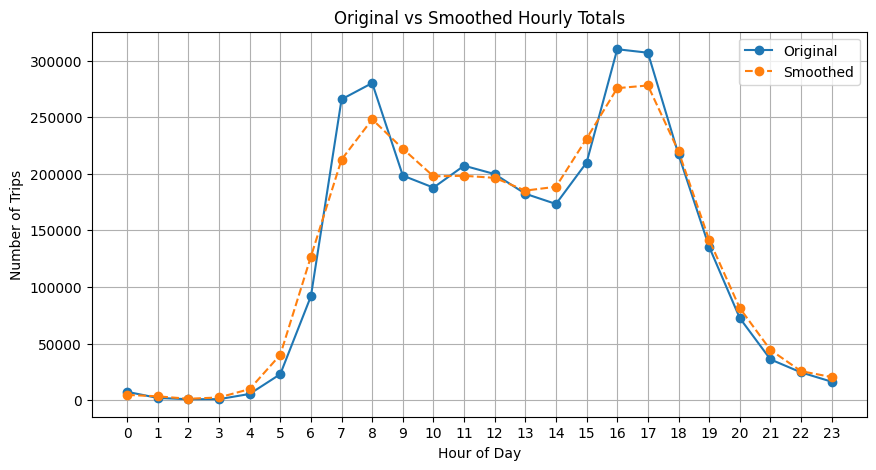

Comparison (raw vs smoothed vs post-split sum):
Hour 00 : raw=7,321 | smoothed=4,641 | sum_sub=4,641
Hour 01 : raw=1,961 | smoothed=3,363 | sum_sub=3,363
Hour 02 : raw=806 | smoothed=1,208 | sum_sub=1,208
Hour 03 : raw=856 | smoothed=2,376 | sum_sub=2,376
Hour 04 : raw=5,466 | smoothed=9,760 | sum_sub=9,760
Hour 05 : raw=22,957 | smoothed=40,078 | sum_sub=40,078
Hour 06 : raw=91,812 | smoothed=126,855 | sum_sub=126,855
Hour 07 : raw=265,796 | smoothed=212,596 | sum_sub=212,596
Hour 08 : raw=280,179 | smoothed=248,130 | sum_sub=248,130
Hour 09 : raw=198,416 | smoothed=222,128 | sum_sub=222,128
Hour 10 : raw=187,789 | smoothed=197,791 | sum_sub=197,791
Hour 11 : raw=207,168 | smoothed=198,231 | sum_sub=198,231
Hour 12 : raw=199,735 | smoothed=196,422 | sum_sub=196,422
Hour 13 : raw=182,363 | smoothed=185,141 | sum_sub=185,141
Hour 14 : raw=173,325 | smoothed=188,550 | sum_sub=188,550
Hour 15 : raw=209,962 | smoothed=231,121 | sum_sub=231,121
Hour 16 : raw=310,076 | smoothed=275,674 | sum

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Hàm chuyển số giờ dạng thập phân thành string "HH.MM" (MM phút) ---
def format_hours_decimal_as_hhmm(dec: float) -> str:
    """
    Chuyển decimal hours (ví dụ 7.333333) → "HH.MM" (MM là phút).
    Cách làm:
      h_part = int(dec)
      m_part = round((dec - h_part) * 60)
      nếu m_part == 60 thì h_part += 1, m_part = 0
    Trả về f"{h_part:02d}.{m_part:02d}".
    """
    h_part = int(dec)
    m_part = int(round((dec - h_part) * 60))
    if m_part == 60:
        h_part += 1
        m_part = 0
    return f"{h_part:02d}.{m_part:02d}"

# Thư mục gốc chứa OD matrices gốc (mỗi file header là "HH.MM HH.MM")
input_dir = '/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/old-form-all'
# Thư mục lưu OD sau khi smooth & subdivide (vẫn giữ header đúng định dạng HH.MM)
output_dir = '/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/smooth-old-form-all'

# 1. Tạo thư mục đầu ra (nếu có quyền)
try:
    os.makedirs(output_dir, exist_ok=True)
except PermissionError:
    print(f"[WARN] Không thể tạo thư mục: {output_dir}. Hãy kiểm tra quyền hoặc đổi sang thư mục khác.")

# 2. Đọc gốc, tính raw_totals
hourly_od_data = {}  # Lưu DataFrame mỗi giờ
raw_totals = []      # Tổng raw mỗi giờ

for h in range(24):
    fname = f"od_matrix_{h:02d}.txt"
    fpath = os.path.join(input_dir, fname)
    with open(fpath, 'r') as f:
        lines = f.readlines()
    data_lines = lines[3:]  # Bỏ 3 dòng header
    origins, destinations, counts = [], [], []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 3:
            origins.append(int(parts[0]))
            destinations.append(int(parts[1]))
            counts.append(int(parts[2]))
    df = pd.DataFrame({'origin': origins, 'destination': destinations, 'count': counts})
    hourly_od_data[h] = df
    raw_totals.append(df['count'].sum())

raw_totals = np.array(raw_totals)

# 3. Tính smoothed_totals (rolling mean window=3)
df_totals = pd.DataFrame({'hour': np.arange(24), 'raw': raw_totals})
df_totals['smoothed'] = df_totals['raw'].rolling(window=3, center=True, min_periods=1).mean()

# In kết quả smoothed
print("Total trips by hour (smoothed):")
for h, val in zip(df_totals['hour'], df_totals['smoothed']):
    print(f"  Hour {h:02d} : {val:,.2f}")
print()

# 4. Vẽ biểu đồ Original vs Smoothed
plt.figure(figsize=(10,5))
plt.plot(df_totals['hour'], df_totals['raw'], marker='o', label='Original')
plt.plot(df_totals['hour'], df_totals['smoothed'], marker='o', linestyle='--', label='Smoothed')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Original vs Smoothed Hourly Totals')
plt.xticks(np.arange(24))
plt.grid(True)
plt.legend()
plt.show()

# 5. Chia sub‐interval dựa trên smoothed
def get_splits_for_hour(h):
    if h in [7, 8, 16, 17]:
        return 3
    elif 7 <= h <= 19:
        return 2
    else:
        return 1

subinterval_info = {}  # hour -> list of sub dicts

for h in range(24):
    f_h = df_totals.loc[h, 'smoothed']
    f_h_next = df_totals.loc[h+1, 'smoothed'] if h < 23 else df_totals.loc[23, 'smoothed']
    total_sm = f_h  # Sử dụng smoothed[h] làm "tổng" cho giờ h

    m = get_splits_for_hour(h)
    dt = 1.0 / m
    trap_counts = []
    for j in range(m):
        f_t0 = f_h + (f_h_next - f_h) * (j * dt)
        f_t1 = f_h + (f_h_next - f_h) * ((j + 1) * dt)
        sub_raw = (f_t0 + f_t1) / 2.0 * dt
        trap_counts.append(sub_raw)
    sum_trap = sum(trap_counts)
    scale = total_sm / sum_trap if sum_trap > 0 else 0

    # Chia integer, phần dư cộng vào sub cuối
    int_sub = []
    cum = 0
    for j in range(m):
        if j < m - 1:
            cnt = int(np.floor(trap_counts[j] * scale))
            int_sub.append(cnt)
            cum += cnt
        else:
            cnt = int(round(total_sm)) - cum
            int_sub.append(cnt)

    # Lưu thông tin sub với start_hour/end_hour dạng decimal
    sub_list = []
    for j in range(m):
        start_hr = round(h + j * dt, 6)
        end_hr   = round(h + (j + 1) * dt, 6)
        start_s = int(start_hr * 3600)
        end_s   = int(end_hr * 3600)
        sub_list.append({
            'sub_index': j+1,
            'splits': m,
            'start_hour_dec': start_hr,
            'end_hour_dec': end_hr,
            'start_sec': start_s,
            'end_sec': end_s,
            'sub_count': int_sub[j]
        })
    subinterval_info[h] = sub_list

# 6. Hàm phân bổ OD vào sub
def allocate_od_to_subintervals(df_od, sub_counts):
    """
    df_od: DataFrame cho một giờ, cột 'count'
    sub_counts: list, tổng của sub phải khớp = sum(round(smoothed[h]))
    Trả về m DataFrame: mỗi DataFrame có (origin, destination, count_sub)
    """
    total = df_od['count'].sum()
    if total == 0:
        # Trả về m bảng rỗng nếu giờ không có chuyến
        return [pd.DataFrame({'origin': [], 'destination': [], 'count': []}) for _ in sub_counts]

    df = df_od.copy()
    df['fraction'] = df['count'] / total
    m = len(sub_counts)

    # Tính ideal, floor, frac
    for j in range(m):
        df[f'ideal_{j}'] = df['fraction'] * sub_counts[j]
        df[f'floor_{j}'] = np.floor(df[f'ideal_{j}'])
        df[f'frac_{j}']  = df[f'ideal_{j}'] - df[f'floor_{j}']

    sub_dfs = []
    for j in range(m):
        floor_sum = int(df[f'floor_{j}'].sum())
        rem = sub_counts[j] - floor_sum
        df[f'alloc_{j}'] = df[f'floor_{j}'].astype(int)
        if rem > 0:
            df_sorted = df.sort_values(by=f'frac_{j}', ascending=False)
            df.loc[df_sorted.index[:rem], f'alloc_{j}'] += 1
        sub_dfs.append(df[['origin', 'destination', f'alloc_{j}']].rename(columns={f'alloc_{j}':'count'}))
    return sub_dfs

# 7. Chia và xuất file mới (mỗi sub in header "HH.MM HH.MM")
for h in range(24):
    df_od = hourly_od_data[h]
    sub_list = subinterval_info[h]
    sub_counts = [sub['sub_count'] for sub in sub_list]
    sub_dfs = allocate_od_to_subintervals(df_od, sub_counts)

    for info, sub_df in zip(sub_list, sub_dfs):
        sidx = info['sub_index']
        m = info['splits']
        # Chuyển giờ decimal thành HH.MM (MM phút)
        start_str = format_hours_decimal_as_hhmm(info['start_hour_dec'])
        end_str   = format_hours_decimal_as_hhmm(info['end_hour_dec'])
        fname_out = f"od_matrix_{h:02d}_{sidx}of{m}.txt"
        fpath_out = os.path.join(output_dir, fname_out)

        try:
            with open(fpath_out, 'w') as f:
                f.write("$OR;D2\n")
                f.write(f"{start_str} {end_str}\n")  # Ví dụ "07.20 07.40"
                f.write("1.00\n")
                for _, row in sub_df.iterrows():
                    o = int(row['origin'])
                    d = int(row['destination'])
                    c = int(row['count'])
                    if c > 0:
                        f.write(f"{o:8d}{d:8d}{c:8d}\n")
        except PermissionError:
            print(f"[WARN] Không thể ghi file {fpath_out}.")

# 8. Kiểm tra tổng mới (đã dùng smoothed) so với raw
print("Comparison (raw vs smoothed vs post-split sum):")
for h in range(24):
    raw_val = raw_totals[h]
    smooth_val = df_totals.loc[h, 'smoothed']
    post_split = sum(sub['sub_count'] for sub in subinterval_info[h])
    print(f"Hour {h:02d} : raw={raw_val:,.0f} | smoothed={smooth_val:,.0f} | sum_sub={post_split:,.0f}")


In [ ]:
import os
from collections import defaultdict

# === Thay đổi đường dẫn cho đúng với môi trường của bạn ===
root_dir = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/smooth-old-form-all"

def is_od_file(fname):
    """
    Nhận diện file OD mới: bắt đầu bằng "od_matrix_" và kết thúc bằng ".txt"
    Ví dụ:
      - od_matrix_00.txt
      - od_matrix_07_1of3.txt
      - od_matrix_16_2of3.txt
    """
    return fname.startswith("od_matrix_") and fname.endswith(".txt")

# Tổng hợp các con số
directed_totals = defaultdict(float)   # {(origin, destination): tổng chuyến}
intra_totals = defaultdict(float)      # {region: tổng chuyến nội vùng (origin==dest)}
time_totals = defaultdict(float)       # {"HH" hoặc "HH_JofM": tổng chuyến của sub‐interval}
grand_total = 0.0
inter_total = 0.0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for fname in filenames:
        if not is_od_file(fname):
            continue

        # Lấy phần time_id: everything between "od_matrix_" và ".txt"
        # Ví dụ: od_matrix_07_1of3.txt -> time_id = "07_1of3"
        #         od_matrix_12.txt      -> time_id = "12"
        time_id = fname[len("od_matrix_"):-len(".txt")]

        fpath = os.path.join(dirpath, fname)
        try:
            with open(fpath, "r", encoding="utf-8") as f:
                lines = f.readlines()
        except Exception as e:
            print(f"[WARN] Không thể đọc file {fpath}: {e}")
            continue

        # Bỏ 3 dòng header
        data_lines = lines[3:]
        file_total = 0.0

        for raw in data_lines:
            line = raw.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 3:
                continue

            origin = parts[0]
            destination = parts[1]
            try:
                value = float(parts[2])
            except ValueError:
                continue

            # Cộng dồn directed
            directed_totals[(origin, destination)] += value
            grand_total += value
            file_total += value

            # Nếu origin == destination → intra‐region
            if origin == destination:
                intra_totals[origin] += value
            else:
                inter_total += value

        # Ghi tổng cho time_id (sub‐interval này)
        time_totals[time_id] += file_total

# --- Bổ sung: tính Total trips by hour (không sub‐interval) ---
hourly_totals = defaultdict(float)
for time_id, tot in time_totals.items():
    # Lấy phần trước dấu "_" nếu có, ví dụ "07_2of3" → "07"; nếu không có "_" thì time_id vốn là "HH"
    hour = time_id.split("_")[0]
    hourly_totals[hour] += tot

# Tìm tất cả các region (origin/destination unique)
all_regions = set()
for (o, d) in directed_totals.keys():
    all_regions.add(o)
    all_regions.add(d)
# Sắp xếp theo giá trị số (giả định origin, destination là chuỗi số)
all_regions = sorted(all_regions, key=lambda r: int(r))

# In kết quả
print("----- DETAILED TRIP STATISTICS -----")
print(f"Total trips (all)                       : {grand_total:,.2f}")
print(f"Total intra-region trips (O = D)        : {sum(intra_totals.values()):,.2f}")
print(f"Total inter-region trips (O ≠ D)        : {inter_total:,.2f}")
print()

# In thêm: Total trips by hour (tổng không phân sub‐interval)
print("Total trips by hour (no sub-interval):")
for hour in sorted(hourly_totals.keys(), key=lambda x: int(x)):
    print(f"  Hour {hour:<8} : {hourly_totals[hour]:,.2f}")
print()

# Tổng theo mỗi time_id (sub‐interval)
print("Total trips by time (sub-interval ID):")
# Sắp xếp theo thứ tự hour rồi sub (dựa vào hour phần trước dấu "_")
for time_id in sorted(time_totals.keys(), key=lambda x: int(x.split("_")[0])):
    total_for_time = time_totals[time_id]
    print(f"  Time {time_id:<8} : {total_for_time:,.2f}")
print()

print("Intra-region totals (origin == destination):")
for region in all_regions:
    intra = intra_totals.get(region, 0.0)
    print(f"  Region {region:>3} : {intra:,.2f}")
print()

print("Inter-region flows (directed and undirected):")
for i, origin in enumerate(all_regions):
    for destination in all_regions[i+1:]:
        od = directed_totals.get((origin, destination), 0.0)
        do_ = directed_totals.get((destination, origin), 0.0)
        combined = od + do_

        if combined > 0:
            print(f"  {origin} -> {destination} : {od:,.2f}")
            print(f"  {destination} -> {origin} : {do_:,.2f}")
            print(f"  {origin} <-> {destination} : {combined:,.2f}")
            print()


FileNotFoundError: [Errno 2] No such file or directory: '/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/total_scenario/edge2region.csv'